# HFA Mixed Effects Models
Created: 08/08/24 \
Updated: 08/14/2024 

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08152024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("talk")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load Regression DF

In [9]:
band = 'hfa'

In [10]:
band_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
band_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [11]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [12]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [13]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
count_thresh = 50

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=count_thresh].tolist()

keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg']

In [14]:
####### NEW DATA FRAME 
reg_df = band_df.copy()
reg_df = reg_df[reg_df.roi.isin(keep_rois)]
len(reg_df)

222615

In [15]:
np.max(reg_df.band_pow)

4.111088307352885

In [16]:
np.min(reg_df.band_pow)

-0.948025564176362

# POW ~ Outcome Vars Regressions

In [17]:
# ###### BIC Testing - 
# final_vars   = ['decisionCPE'] # BIC -249856.56792628395
# final_vars   = ['RPE','decisionCPE'] # -249848.6044250971
# final_vars   = ['TrialEV','RPE','decisionCPE'] # -249828.8870830534
# final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE'] # -257798.71952021663
# final_vars   = ['C(TrialType)','TrialEV', 'TotalProfit', 'decisionCPE'] # -257467.88502797886
# final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE'] # -257748.64046136508
# final_vars   = ['C(GambleChoice)', 'TrialEV', 'decisionCPE'] # -250250.11090162286
# final_vars   = ['TrialEV', 'TotalProfit', 'decisionCPE'] # -257221.93331664318
# final_vars   = ['C(GambleChoice)', 'decisionCPE'] # -250288.05753364015
# final_vars   = ['TotalProfit', 'decisionCPE'] # -257227.6930595564
# final_vars   = ['TrialEV', 'decisionCPE'] # -249848.25629109397
# final_vars   = ['C(TrialType)','decisionCPE'] # -249890.84101338993
# final_vars   = ['C(TrialType)','TotalProfit', 'decisionCPE'] # -257407.7333453585
# final_vars   = ['C(TrialType)','TrialEV',  'decisionCPE'] # -249897.80612570498


In [18]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [19]:
# final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE']
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           222592           Method:                      ML         
No. Groups:                 1620             Scale:                       0.0201     
Min. group size:            65               Log-Likelihood:              114149.3283
Max. group size:            148              Converged:                   Yes        
Mean group size:            137.4                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.018    0.002 -11.184 0.000 -0.021 -0.015
C(GambleChoice)[T.safe]                    0.004    0.001   4.003 0.000  0.002

-228113.96023379196


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [20]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
# final_vars   = ['C(GambleChoice)','TrialEV','TotalProfit','decisionCPE']
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']

In [74]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [75]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

In [76]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TotalProfit,raw_decisionCPE,Intercept,GambleChoice,TotalProfit,decisionCPE,band
0,DA023_lac1-lac2,DA023,acc,14,-0.120249,0.002899,-0.003659,0.001811,0.893417,0.015465,-0.024394,0.035208,hfa
1,DA023_lac2-lac3,DA023,acc,14,-0.120249,0.002899,-0.003659,0.001811,0.893417,0.015465,-0.024394,0.035208,hfa
2,DA023_lac3-lac4,DA023,acc,14,-0.120249,0.002899,-0.003659,0.001811,0.893417,0.015465,-0.024394,0.035208,hfa
3,MS002_lacas1-lacas2,MS002,acc,14,-0.286208,-0.004089,0.045405,-0.002293,0.727458,0.008478,0.024670,0.031104,hfa
4,MS002_lacas2-lacas3,MS002,acc,14,-0.286208,-0.004089,0.045405,-0.002293,0.727458,0.008478,0.024670,0.031104,hfa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.259765,0.021496,-0.126005,0.022338,1.250640,0.044417,-0.128040,0.075151,hfa
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.259765,0.021496,-0.126005,0.022338,1.250640,0.044417,-0.128040,0.075151,hfa
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.259765,0.021496,-0.126005,0.022338,1.250640,0.044417,-0.128040,0.075151,hfa
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.259765,0.021496,-0.126005,0.022338,1.250640,0.044417,-0.128040,0.075151,hfa


In [77]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [78]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [79]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [80]:
fe_results['roi_cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]

In [81]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=6.155722722693342, pvalue=3.3942392486170712e-06, df=22),
 'dmpfc': TtestResult(statistic=29.60403244144333, pvalue=3.230091325228424e-19, df=22),
 'amy': TtestResult(statistic=15.522942912534102, pvalue=2.4122351562269034e-14, df=25),
 'sts': TtestResult(statistic=5.096432664829135, pvalue=2.904624796406293e-05, df=25),
 'ains': TtestResult(statistic=7.9707881419848405, pvalue=2.3274904871458977e-06, df=13),
 'vlpfc': TtestResult(statistic=6.915957988499692, pvalue=6.055257676129289e-07, df=22),
 'hpc': TtestResult(statistic=12.509744060544381, pvalue=5.257229009879166e-12, df=24),
 'mtg': TtestResult(statistic=17.2496305981793, pvalue=3.3079311501257107e-12, df=17),
 'ofc': TtestResult(statistic=9.457223482579222, pvalue=3.299404420846023e-09, df=22),
 'pins': TtestResult(statistic=13.232173832287428, pvalue=2.2247273806524837e-10, df=17),
 'dlpfc': TtestResult(statistic=11.555612056631556, pvalue=1.4556531212723842e-10, df=21),
 'smg': TtestResult(stati

In [82]:
fe_results

,Intercept,C(GambleChoice)[T.safe],TotalProfit,decisionCPE,roi,roi_cpe_pval
0,1.013666,0.012566,-0.020735,0.033397,acc,0.0000
1,0.987498,0.015960,-0.001440,0.046305,dmpfc,0.0000
2,1.036912,0.012277,-0.010081,0.040191,amy,0.0000
3,1.037266,0.022423,-0.030447,0.023287,sts,0.0000
4,0.988206,0.026968,-0.003634,0.045580,ains,0.0000
5,1.014181,0.013667,0.024227,0.029105,vlpfc,0.0004
6,0.995961,0.004309,0.006828,0.033207,hpc,0.0000
7,1.088302,-0.003134,-0.000127,0.048110,mtg,0.0000
8,1.036359,0.009052,-0.003232,0.037829,ofc,0.0000
9,1.106616,-0.012058,-0.000608,0.028579,pins,0.0004


In [83]:
fe_results.roi_cpe_pval

0     0.0000
1     0.0000
2     0.0000
3     0.0000
4     0.0000
5     0.0004
6     0.0000
7     0.0000
8     0.0000
9     0.0004
10    0.0000
11    0.1437
12    0.0000
13    0.0000
Name: roi_cpe_pval, dtype: float64

In [84]:
bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha

0.0035714285714285718

In [85]:
sig_rois = fe_results.roi[fe_results.roi_cpe_pval <= bonferr_alpha].tolist()
sig_rois

['acc',
 'dmpfc',
 'amy',
 'sts',
 'ains',
 'vlpfc',
 'hpc',
 'mtg',
 'ofc',
 'pins',
 'dlpfc',
 'stg',
 'thalamus']

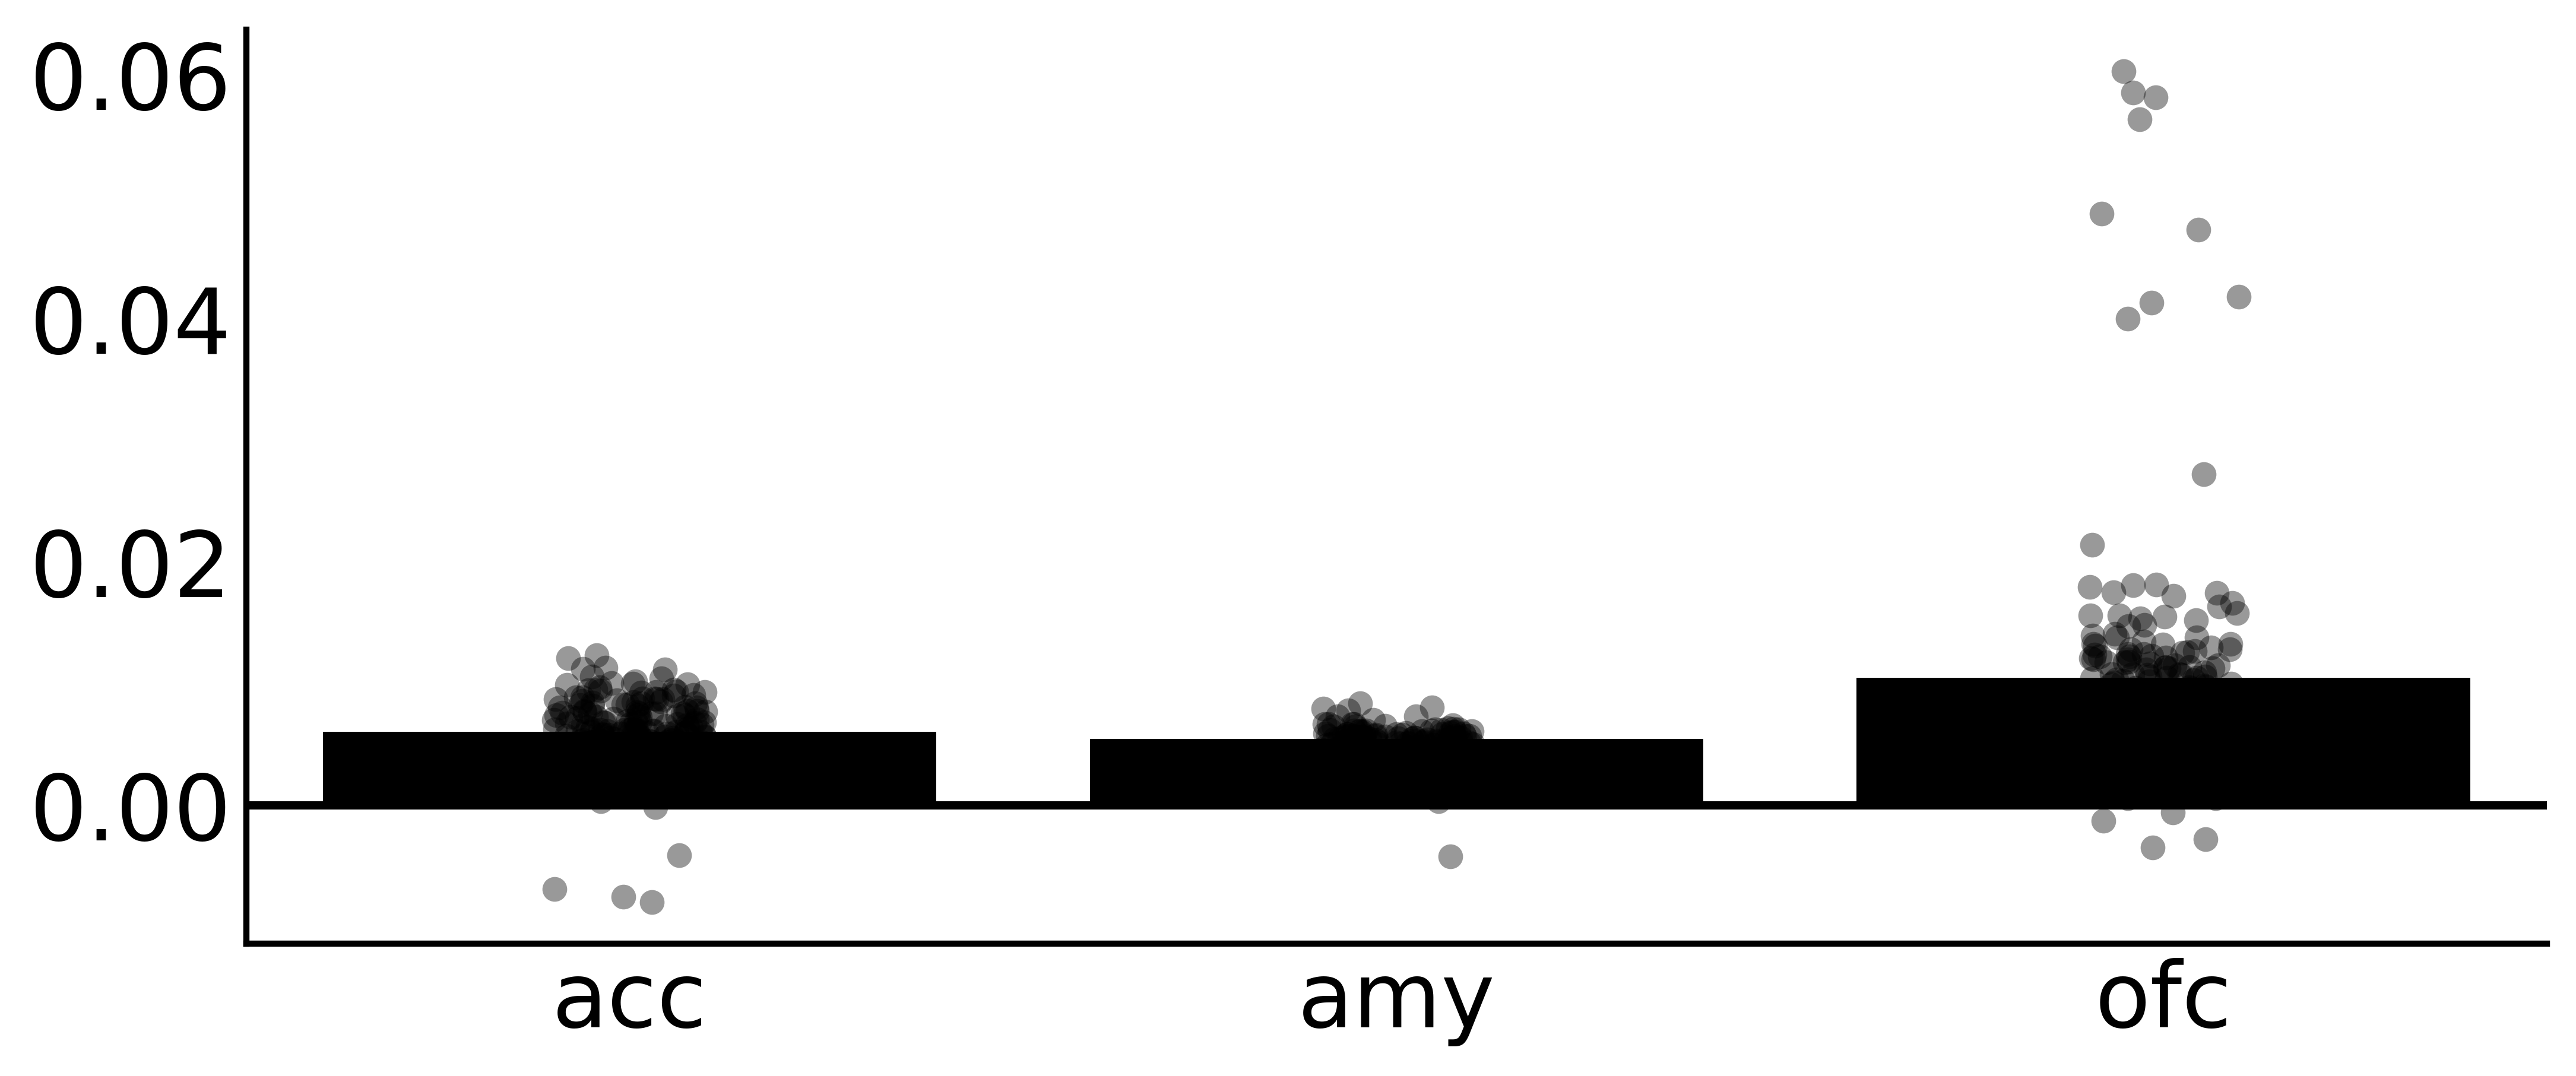

In [32]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois)


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


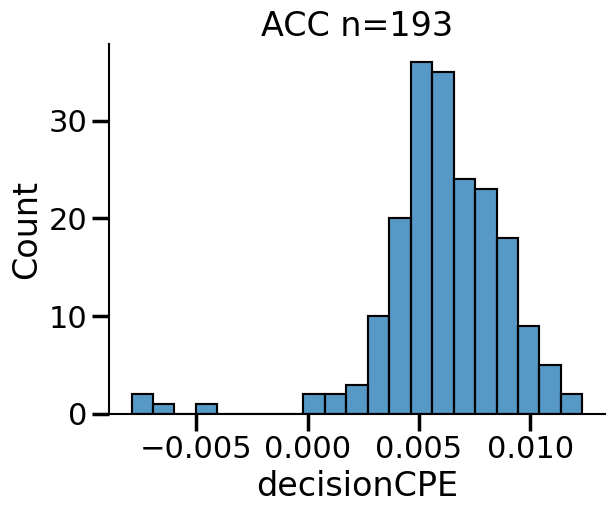

In [33]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
plt.title(f'ACC n={n}')

sns.despine()

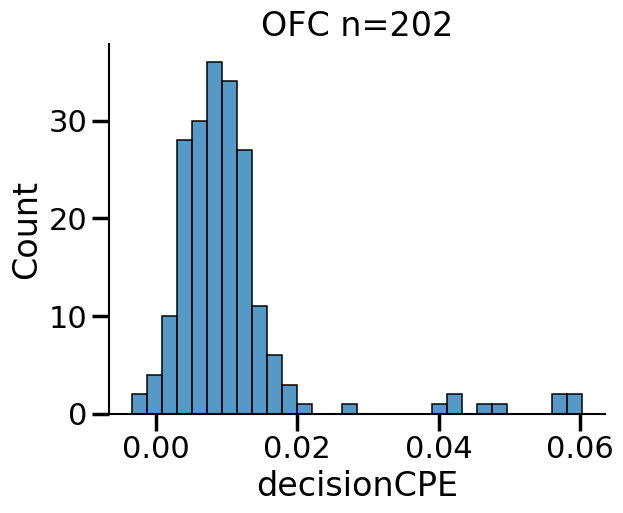

In [34]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
plt.title(f'OFC n={n}')

sns.despine()

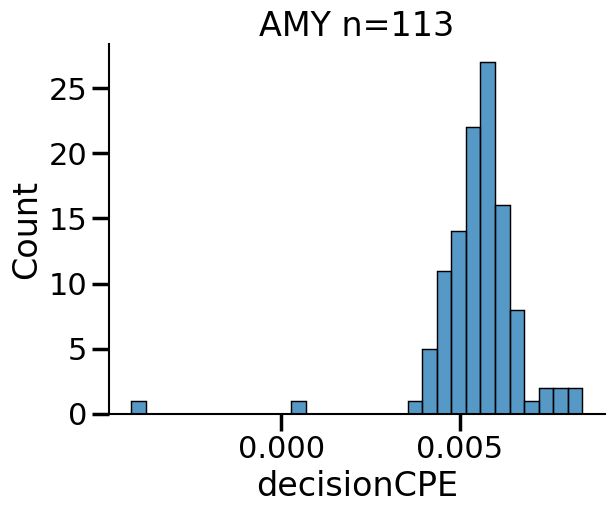

In [35]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'amy'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'amy'].decisionCPE)
plt.title(f'AMY n={n}')

sns.despine()

In [37]:
sig_rois

['acc', 'amy', 'ofc']

In [38]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.06900120847617304 0.3403340945977883
dmpfc pearsonr -0.016985523646140723 0.8039761119600818
amy pearsonr -0.328570526705721 0.0003807249202020603
sts pearsonr -0.07651849286158882 0.34398307382583737
ains pearsonr -0.2009753256811961 0.09284368383457316
vlpfc pearsonr -0.15438991209787636 0.16607800223389205
hpc pearsonr -0.2554891045745725 0.002783300033890201
mtg pearsonr -0.07978124008456591 0.5552360650283429
ofc pearsonr -0.039041058966048064 0.5811918621806109
pins pearsonr 0.31132684093073526 0.015464854392428671
dlpfc pearsonr -0.06678889812004028 0.49427901986529477
smg pearsonr 0.38975547176543734 0.0012170988687214312
stg pearsonr -0.1484951283364813 0.13058406092261562
thalamus pearsonr 0.08313812194978361 0.5349592319807892


In [39]:
sig_rho

[('amy', -0.328570526705721, 0.0003807249202020603),
 ('hpc', -0.2554891045745725, 0.002783300033890201),
 ('pins', 0.31132684093073526, 0.015464854392428671),
 ('smg', 0.38975547176543734, 0.0012170988687214312)]

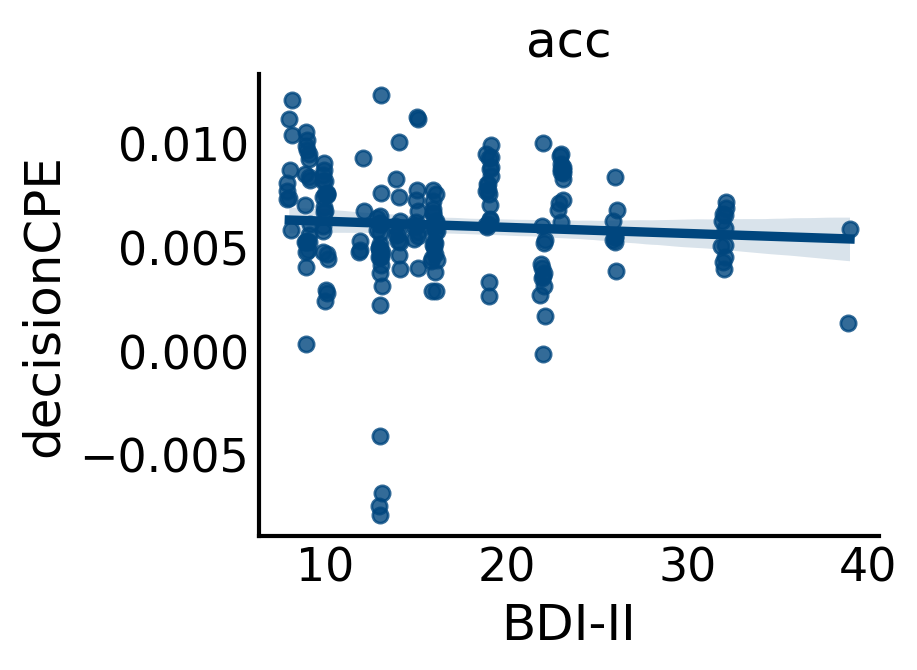

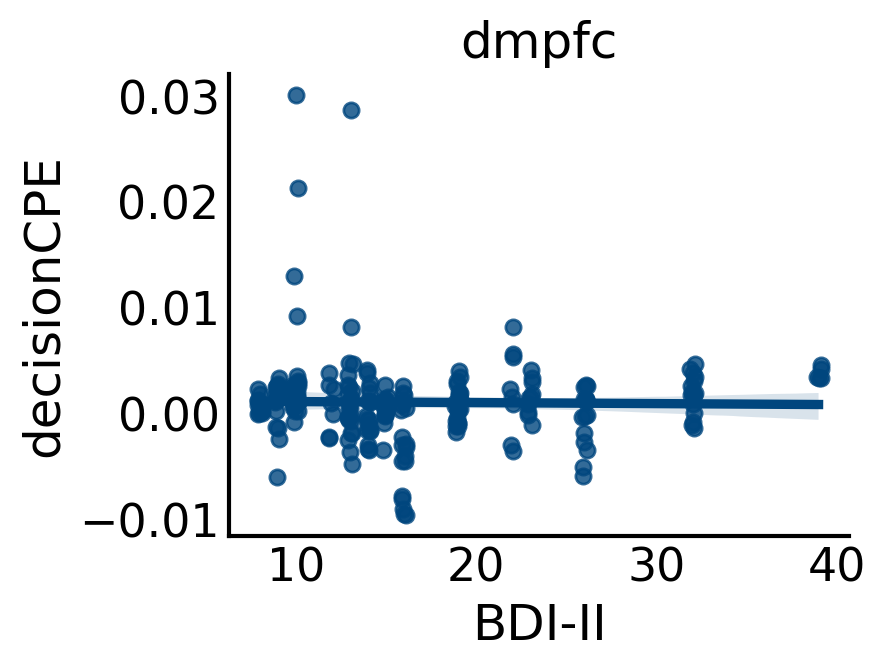

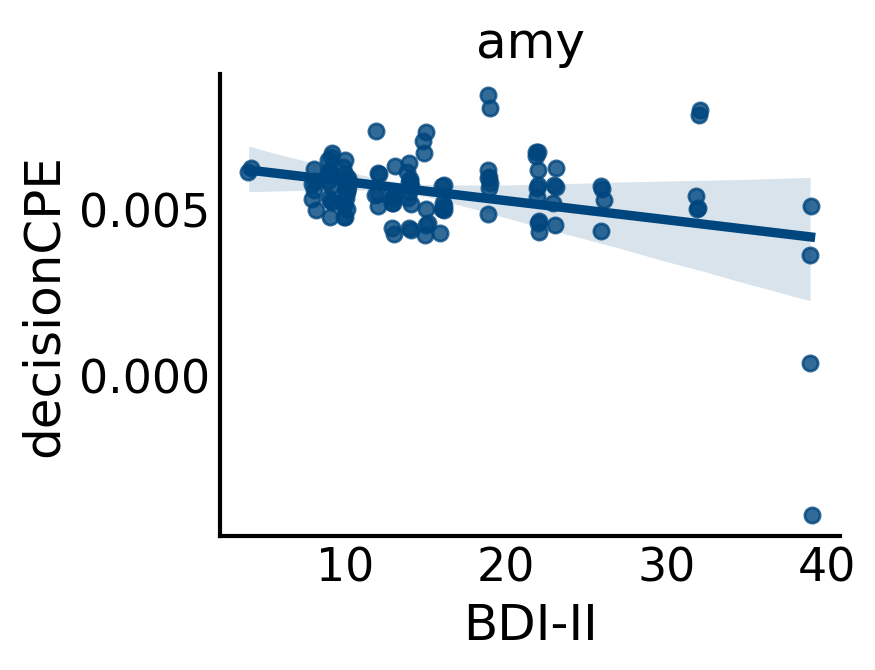

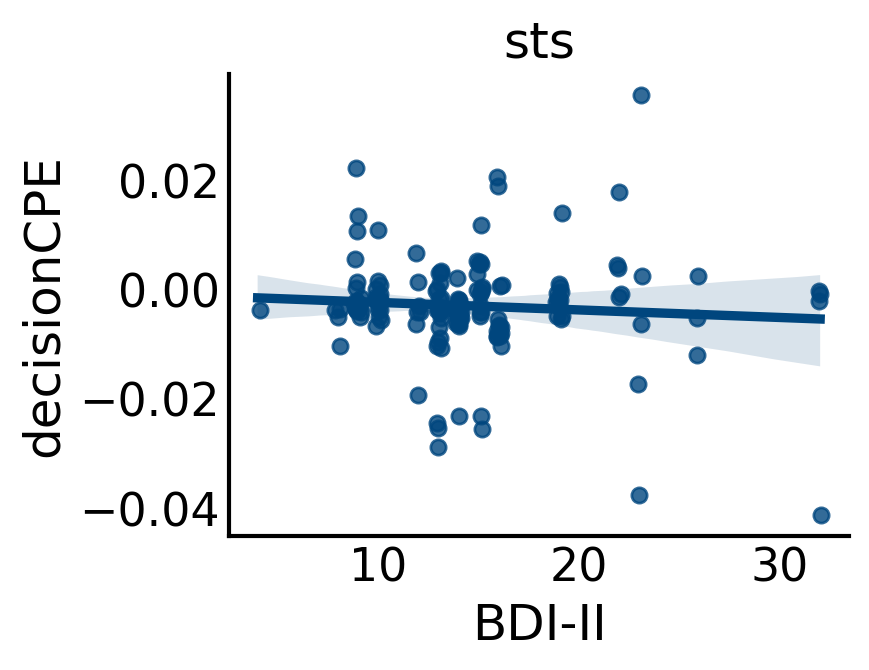

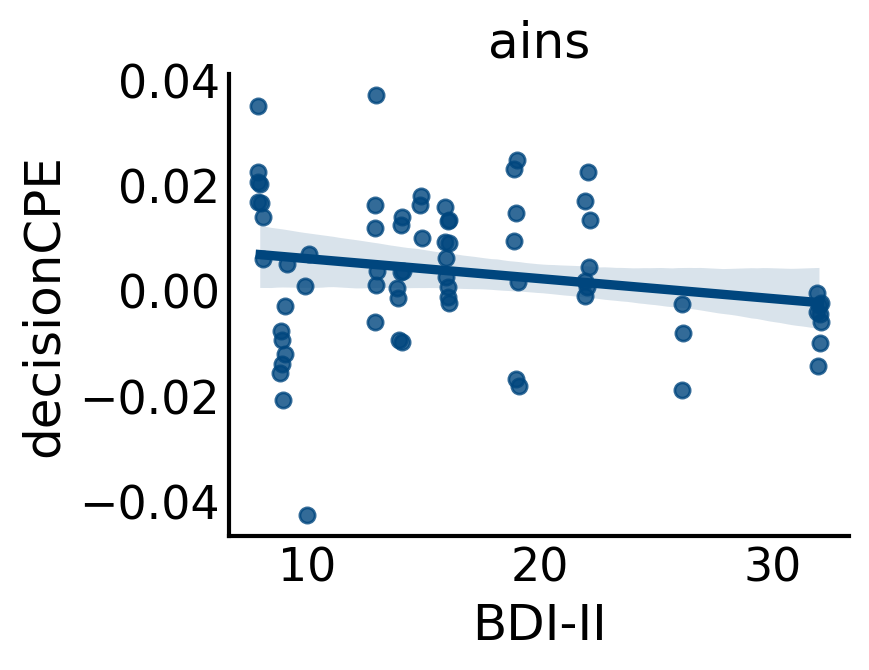

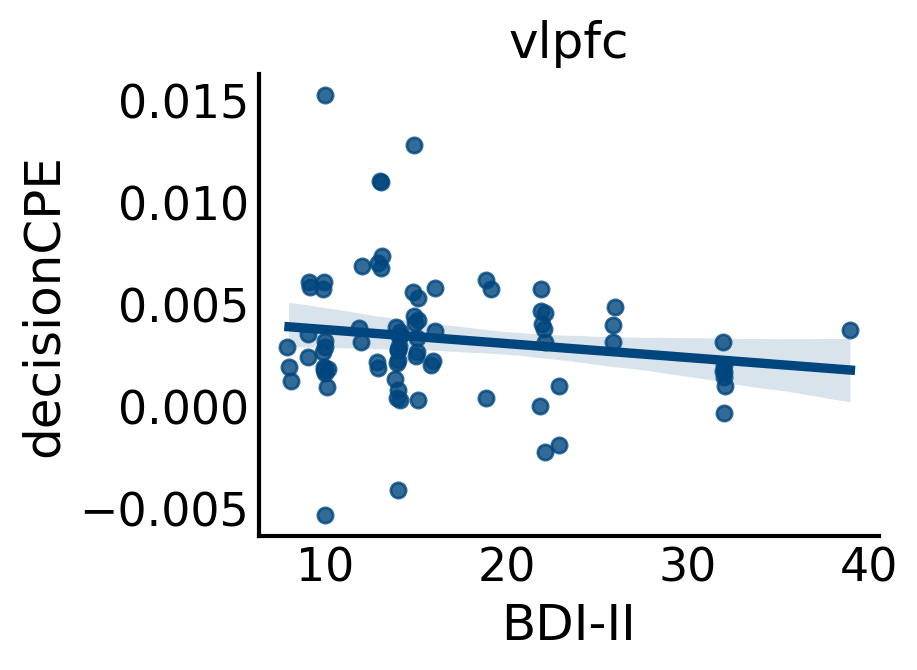

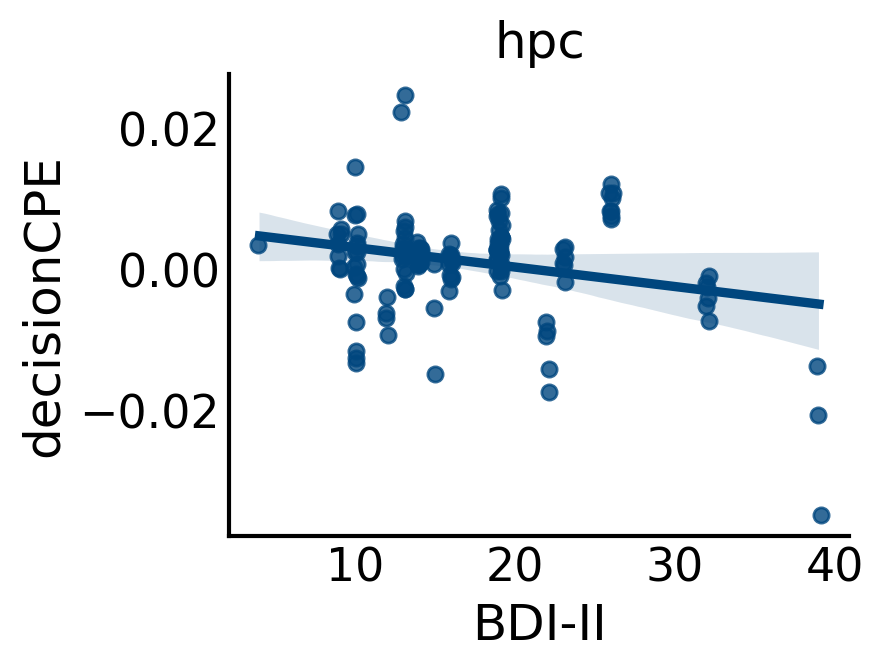

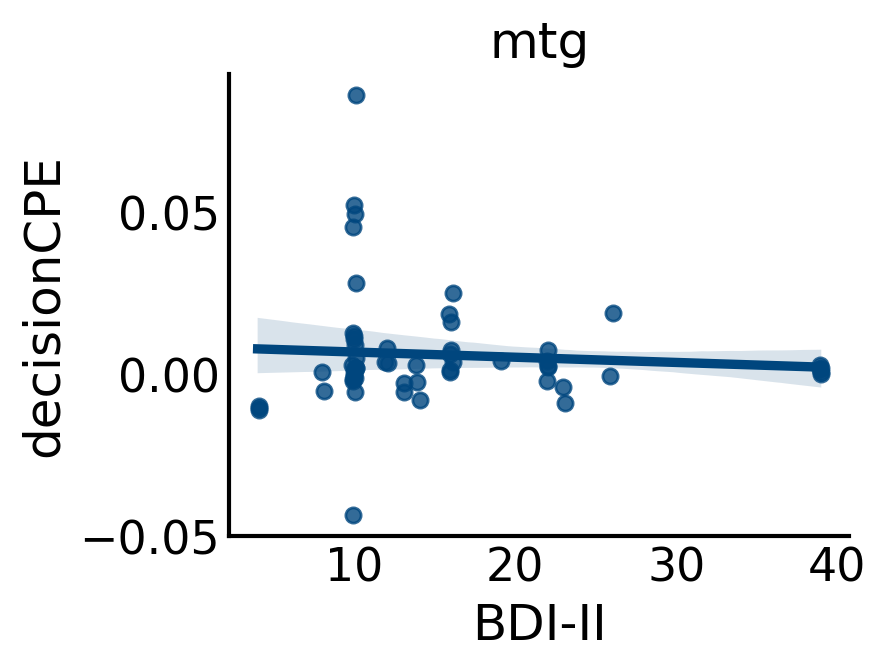

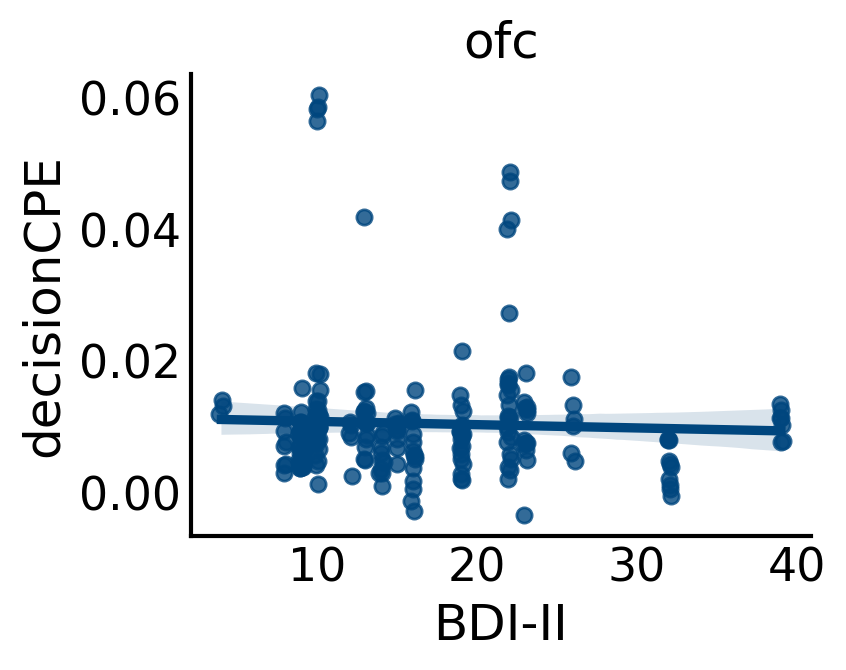

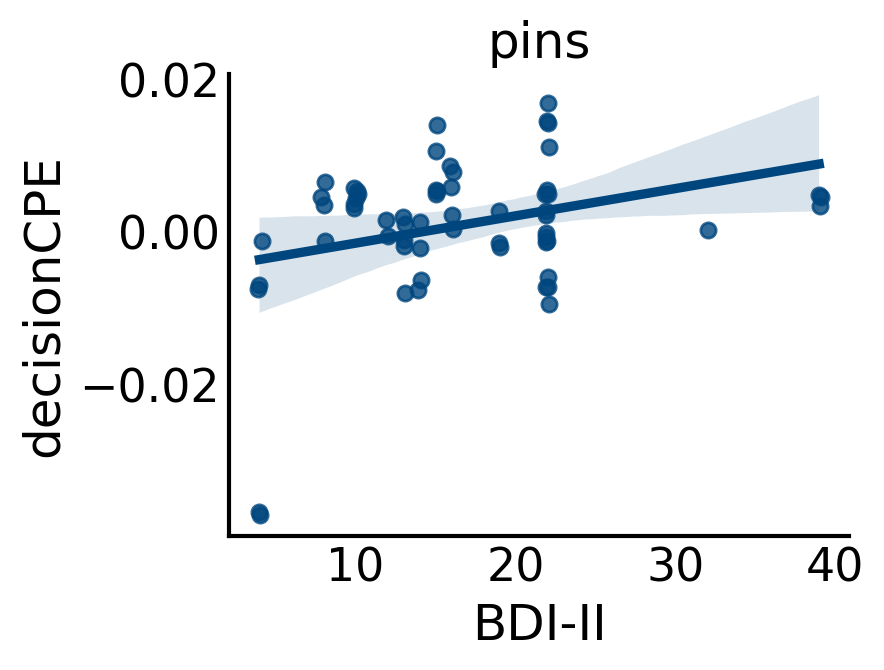

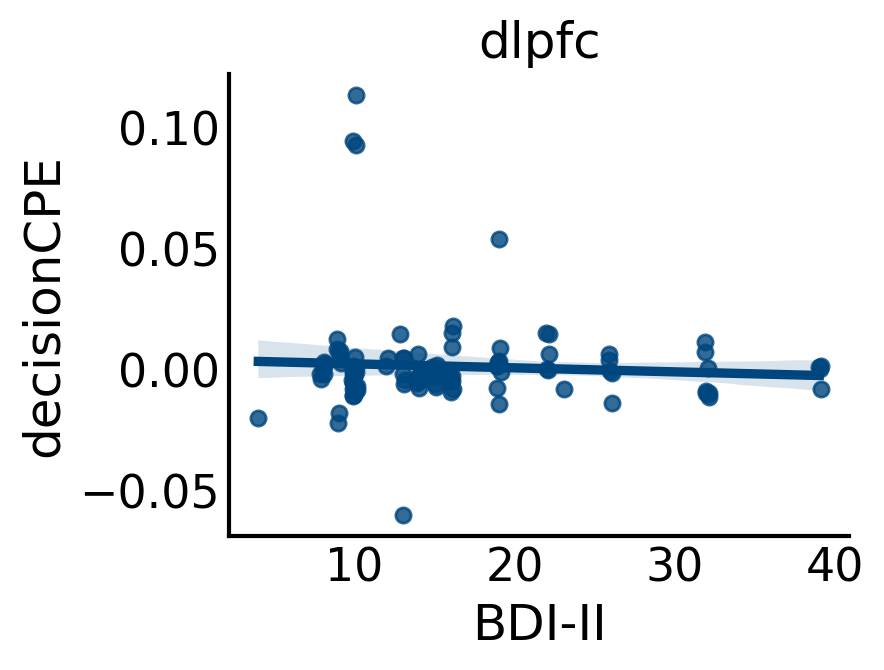

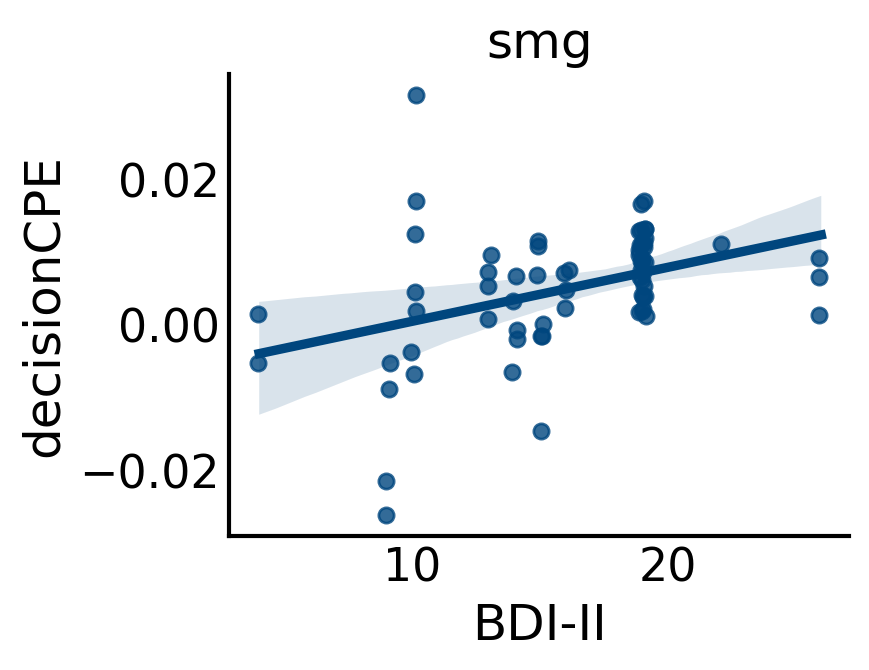

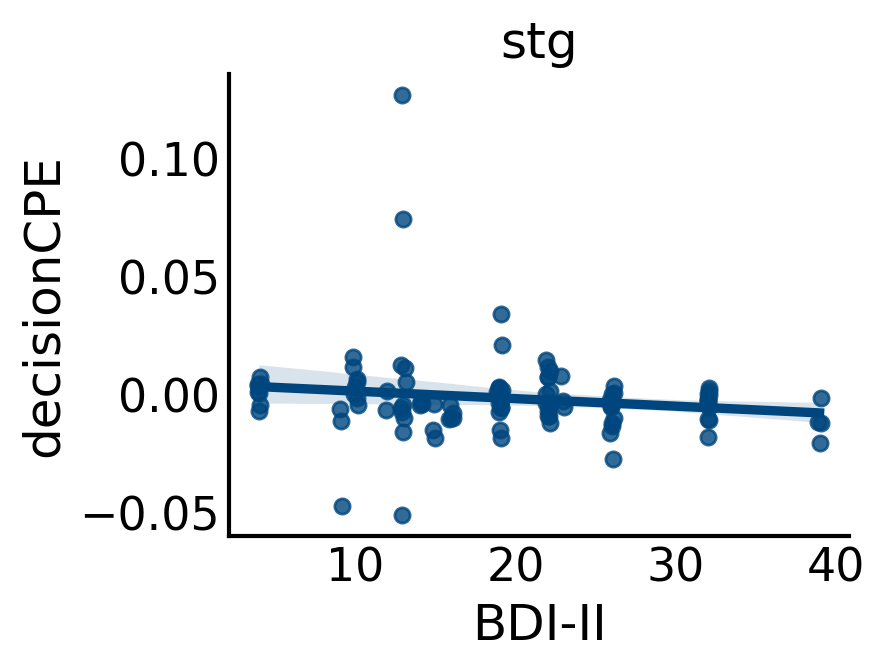

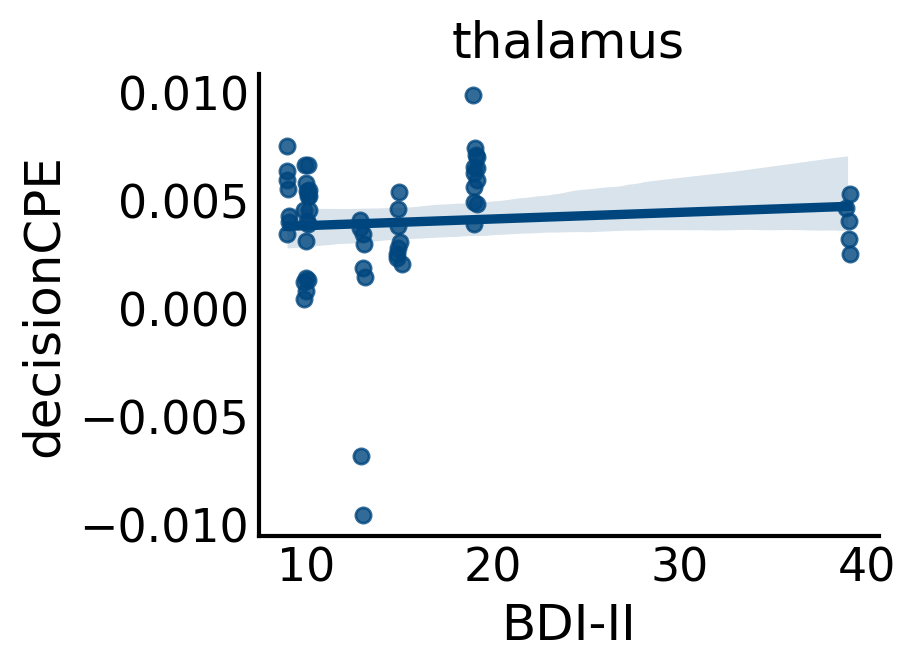

In [40]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    

# RT ~ CPE:Pow Regressions

In [41]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

In [42]:
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']
rt_fit = fit_mixed_model(reg_df,rt_vars,outcome_var,rand_eff_var,reml=False)
print(rt_fit.summary())
rt_fit.bic    

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         logRT_t1   
No. Observations:          222592          Method:                     ML         
No. Groups:                1620            Scale:                      0.1330     
Min. group size:           65              Log-Likelihood:             -95092.6188
Max. group size:           148             Converged:                  Yes        
Mean group size:           137.4                                                  
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               1.032    0.006 178.215 0.000  1.021  1.044
decisionCPE                             0.037    0.002  21.198 0.000  0.034  0.040
band_pow                   

190369.9341119451

In [43]:
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']
rt_fit = fit_mixed_model(reg_df,rt_vars,outcome_var,rand_eff_var,reml=False)
print(rt_fit.summary())
rt_fit.bic    

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         logRT_t1   
No. Observations:          222592          Method:                     ML         
No. Groups:                1620            Scale:                      0.1330     
Min. group size:           65              Log-Likelihood:             -95092.6188
Max. group size:           148             Converged:                  Yes        
Mean group size:           137.4                                                  
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               1.032    0.006 178.215 0.000  1.021  1.044
decisionCPE                             0.037    0.002  21.198 0.000  0.034  0.040
band_pow                   

190369.9341119451


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [44]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']


In [45]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        rt_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [46]:
roi_fit_results['band'] = 'hfa'
roi_fit_results.to_csv(f'{save_dir}RT_hfa_roi_results.csv')

In [47]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_decisionCPE,raw_band_pow,raw_decisionCPE:band_pow,Intercept,decisionCPE,band_pow,decisionCPE:band_pow,band
0,DA023_lac1-lac2,DA023,acc,14,-0.119528,0.007052,0.007460,-0.048301,0.900780,0.039307,0.037652,-0.127055,hfa
1,DA023_lac2-lac3,DA023,acc,14,-0.120053,0.006412,0.021514,-0.053320,0.900256,0.038667,0.051706,-0.132075,hfa
2,DA023_lac3-lac4,DA023,acc,14,-0.119084,0.005966,-0.002179,-0.038849,0.901225,0.038221,0.028013,-0.117603,hfa
3,MS002_lacas1-lacas2,MS002,acc,14,-0.285337,0.007895,0.075980,-0.116421,0.734972,0.040150,0.106172,-0.195175,hfa
4,MS002_lacas2-lacas3,MS002,acc,14,-0.284675,0.007034,0.083136,-0.117735,0.735634,0.039290,0.113328,-0.196490,hfa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.271301,0.035774,0.026251,-0.041111,1.273199,0.091300,-0.076363,0.027979,hfa
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.271487,0.035353,0.069981,0.078158,1.273385,0.090879,-0.032633,0.147248,hfa
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.271143,0.036762,0.002081,-0.050538,1.273041,0.092288,-0.100533,0.018552,hfa
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.271821,0.035714,0.076858,-0.080668,1.273719,0.091240,-0.025756,-0.011578,hfa


In [48]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results['decisionCPE:band_pow'][roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=-9.927385238155754, pvalue=5.21831078306013e-19, df=192),
 'dmpfc': TtestResult(statistic=-0.8327692809590411, pvalue=0.4058989653035714, df=215),
 'amy': TtestResult(statistic=-6.6351183852703945, pvalue=1.2002314387884417e-09, df=112),
 'sts': TtestResult(statistic=22.666454067170037, pvalue=6.404576387966748e-51, df=154),
 'ains': TtestResult(statistic=1.4395302532557848, pvalue=0.15445748358771816, df=70),
 'vlpfc': TtestResult(statistic=-4.265654972478531, pvalue=5.363543194164265e-05, df=81),
 'hpc': TtestResult(statistic=-3.8358611820099755, pvalue=0.0001918650297649689, df=134),
 'mtg': TtestResult(statistic=-1.3776374369237754, pvalue=0.17379620260172815, df=56),
 'ofc': TtestResult(statistic=-1.190280961123764, pvalue=0.2353398912607782, df=201),
 'pins': TtestResult(statistic=5.370991477058032, pvalue=1.390134649018808e-06, df=59),
 'dlpfc': TtestResult(statistic=-3.459017294535893, pvalue=0.0007819766978905643, df=106),
 'smg': TtestResult(stat

In [49]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_decisionCPE,raw_band_pow,raw_decisionCPE:band_pow,Intercept,decisionCPE,band_pow,decisionCPE:band_pow,band
0,DA023_lac1-lac2,DA023,acc,14,-0.119528,0.007052,0.007460,-0.048301,0.900780,0.039307,0.037652,-0.127055,hfa
1,DA023_lac2-lac3,DA023,acc,14,-0.120053,0.006412,0.021514,-0.053320,0.900256,0.038667,0.051706,-0.132075,hfa
2,DA023_lac3-lac4,DA023,acc,14,-0.119084,0.005966,-0.002179,-0.038849,0.901225,0.038221,0.028013,-0.117603,hfa
3,MS002_lacas1-lacas2,MS002,acc,14,-0.285337,0.007895,0.075980,-0.116421,0.734972,0.040150,0.106172,-0.195175,hfa
4,MS002_lacas2-lacas3,MS002,acc,14,-0.284675,0.007034,0.083136,-0.117735,0.735634,0.039290,0.113328,-0.196490,hfa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.271301,0.035774,0.026251,-0.041111,1.273199,0.091300,-0.076363,0.027979,hfa
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.271487,0.035353,0.069981,0.078158,1.273385,0.090879,-0.032633,0.147248,hfa
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.271143,0.036762,0.002081,-0.050538,1.273041,0.092288,-0.100533,0.018552,hfa
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.271821,0.035714,0.076858,-0.080668,1.273719,0.091240,-0.025756,-0.011578,hfa


In [50]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [51]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [52]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [53]:
fe_results['roi_cpepow_pval'] = [roi_fit_dict[roi].pvalues['decisionCPE:band_pow'] for roi in fe_results.roi.tolist()]


In [54]:
fe_results

,Intercept,decisionCPE,band_pow,decisionCPE:band_pow,roi,roi_cpepow_pval
0,1.020309,0.032255,0.030192,-0.078754,acc,NaN
1,0.995251,0.047464,0.084598,-0.004266,dmpfc,0.923083
2,1.042332,0.039033,-0.013892,-0.130674,amy,0.073265
3,1.048365,0.022132,0.012287,0.030791,sts,0.135009
4,1.000003,0.045639,-0.000860,0.029145,ains,0.768782
5,1.019981,0.033011,0.059283,-0.042157,vlpfc,0.416407
6,0.995636,0.030576,-0.026974,-0.046183,hpc,0.382579
7,1.088075,0.049184,-0.008543,-0.006475,mtg,0.874164
8,1.041681,0.038297,0.055975,-0.003231,ofc,0.934470
9,1.100269,0.028127,-0.010635,0.022440,pins,0.716369


In [55]:
bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha

0.0035714285714285718

In [56]:
sig_rois = fe_results.roi[fe_results.roi_cpepow_pval <= bonferr_alpha].tolist()
sig_rois

[]

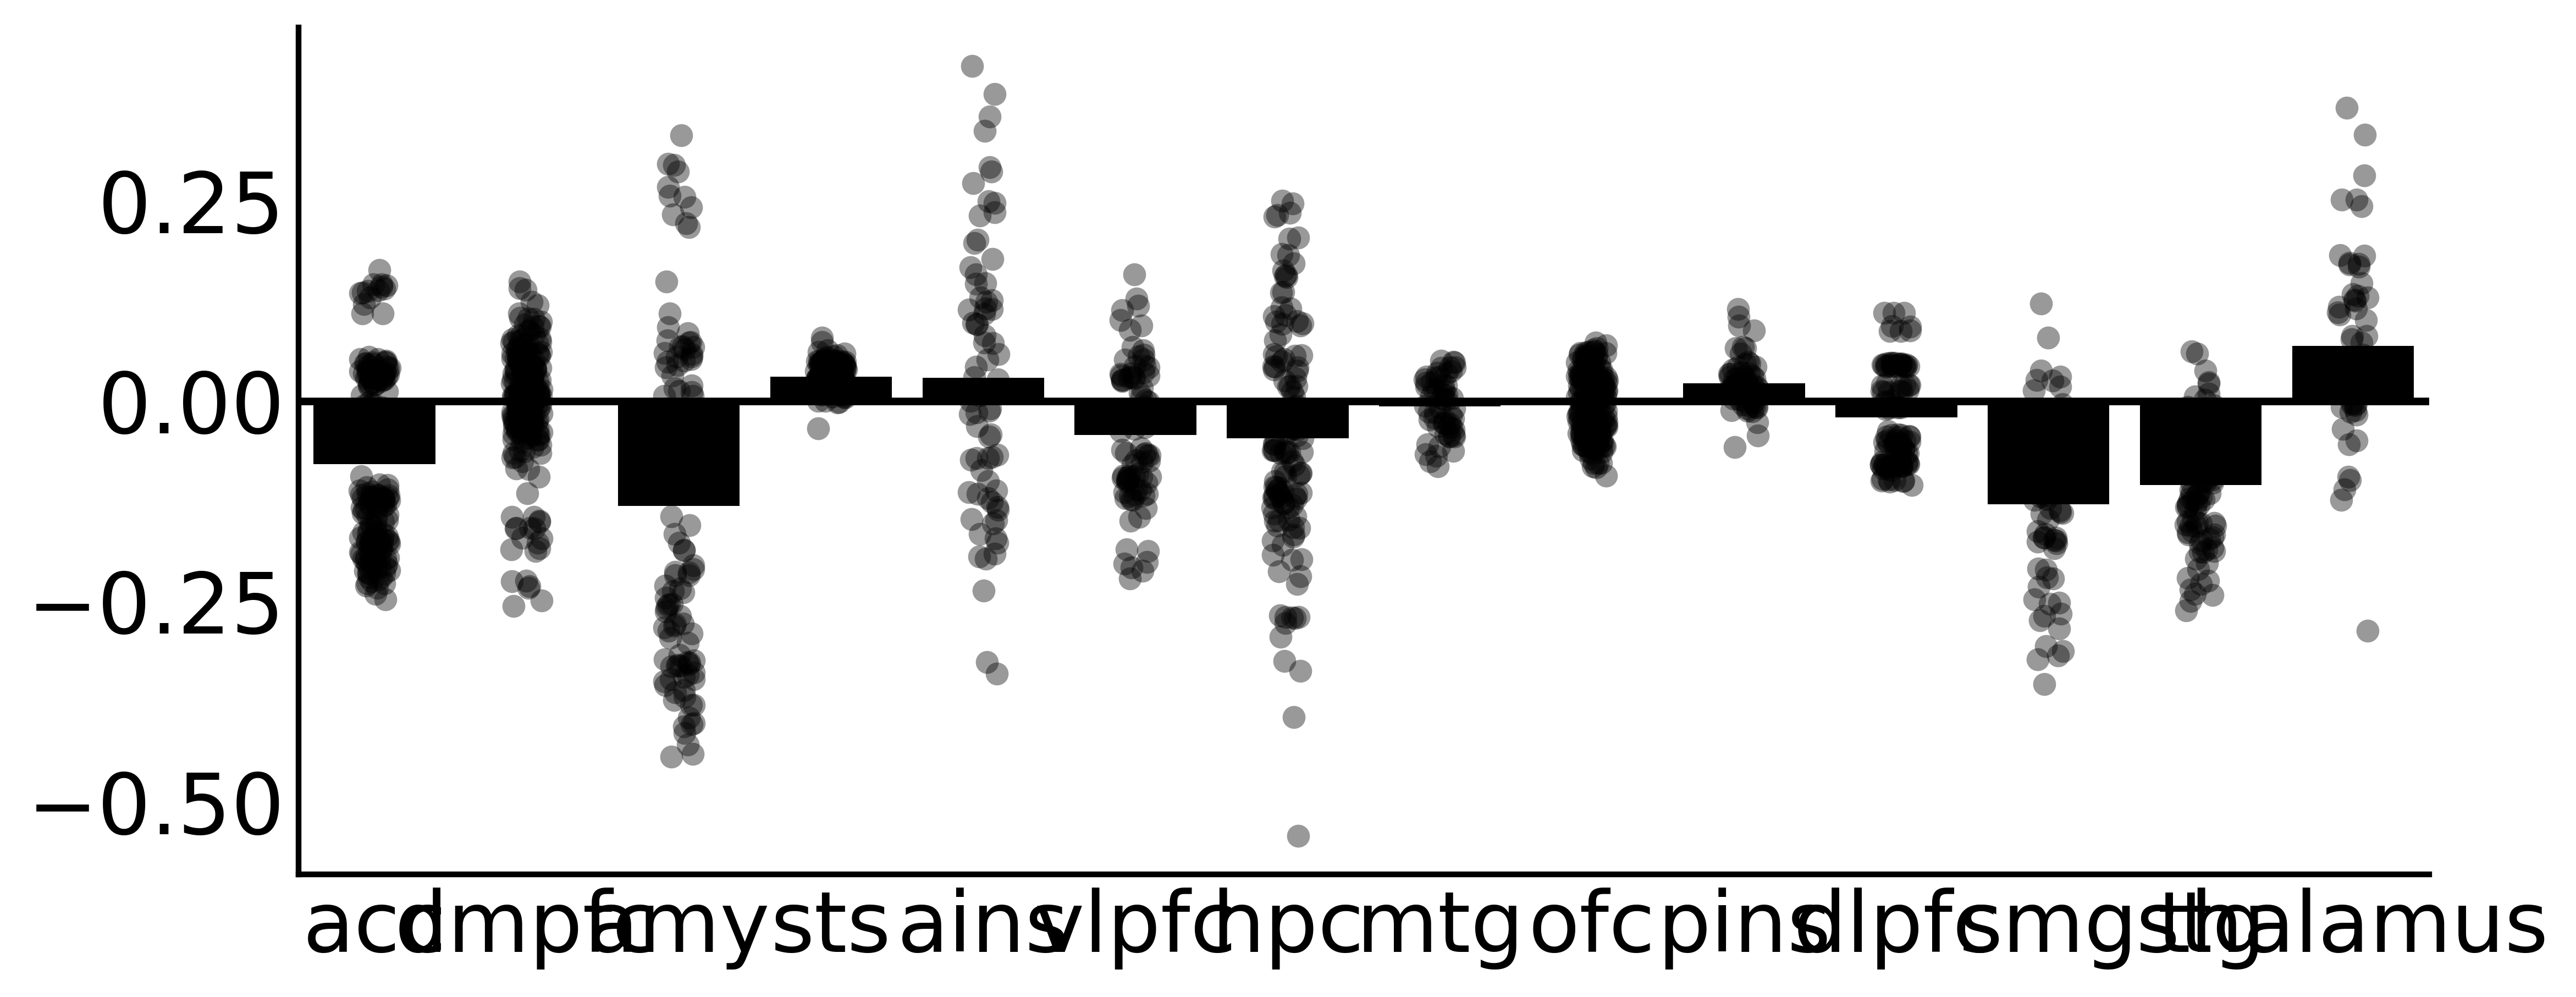

In [57]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE:band_pow')


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


In [58]:
# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')

# sns.despine()

In [59]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data['decisionCPE:band_pow'])
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.28835352978602585 4.769796570267023e-05
dmpfc pearsonr -0.5255499837538269 9.761161209218678e-17
amy pearsonr -0.1729520383044871 0.06696714495683026
sts pearsonr -0.10725769294544625 0.18405464188718884
ains pearsonr 0.24288226988768039 0.0412601207969919
vlpfc pearsonr -0.36248883059771214 0.0008178642853564373
hpc pearsonr -0.30413907806465734 0.00033545724683291353
mtg pearsonr 0.09165300591619437 0.4977310457868482
ofc pearsonr -0.23268820247239005 0.000860824073978219
pins pearsonr 0.25755715707072396 0.04695365104061456
dlpfc pearsonr -0.07358362741186558 0.45130765816754675
smg pearsonr -0.07287715616651627 0.5608909121435857
stg pearsonr 0.02097226504620887 0.8318319342454643
thalamus pearsonr 0.2505452137870541 0.0578363479600658


In [60]:
sig_rho

[('acc', -0.28835352978602585, 4.769796570267023e-05),
 ('dmpfc', -0.5255499837538269, 9.761161209218678e-17),
 ('ains', 0.24288226988768039, 0.0412601207969919),
 ('vlpfc', -0.36248883059771214, 0.0008178642853564373),
 ('hpc', -0.30413907806465734, 0.00033545724683291353),
 ('ofc', -0.23268820247239005, 0.000860824073978219),
 ('pins', 0.25755715707072396, 0.04695365104061456)]

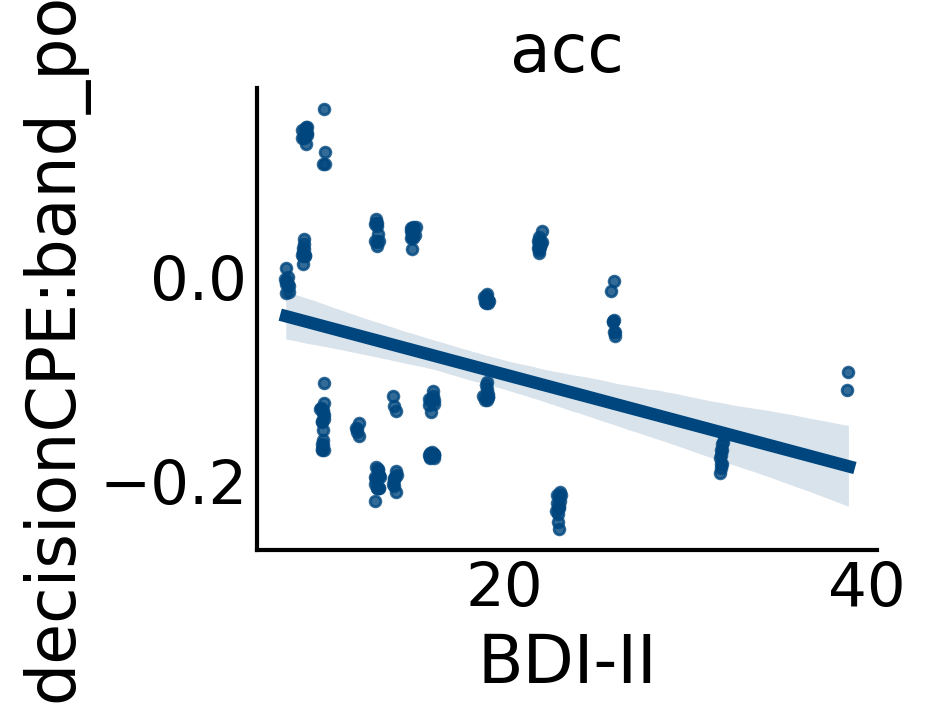

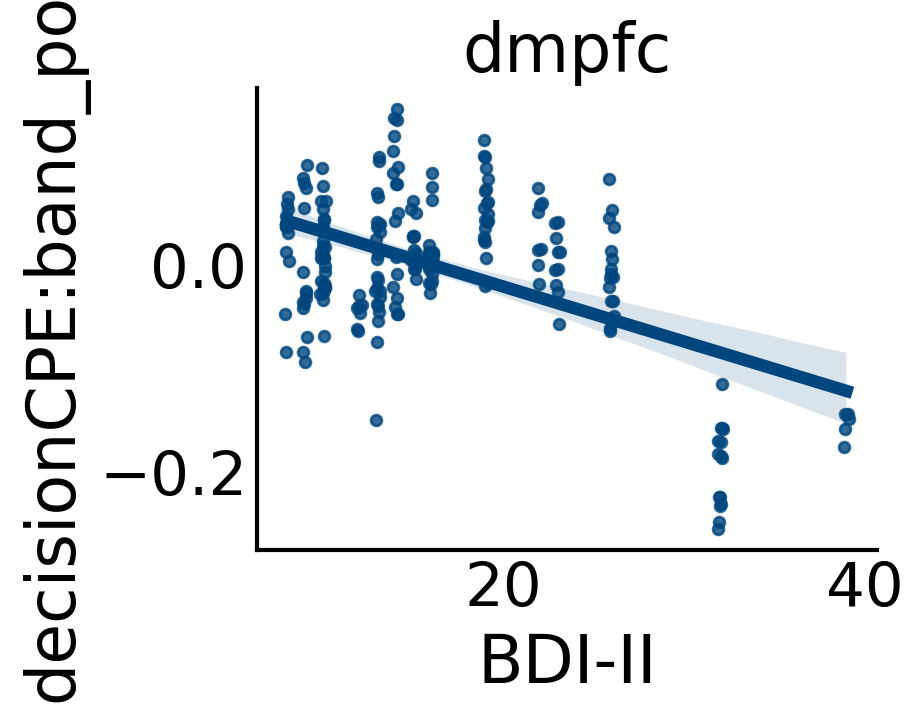

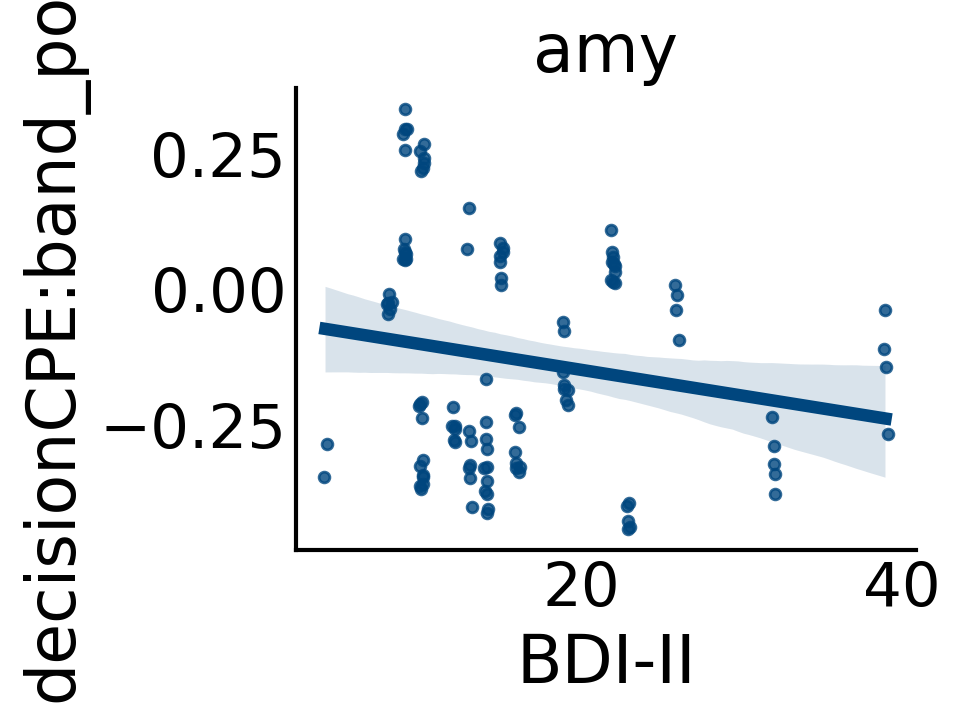

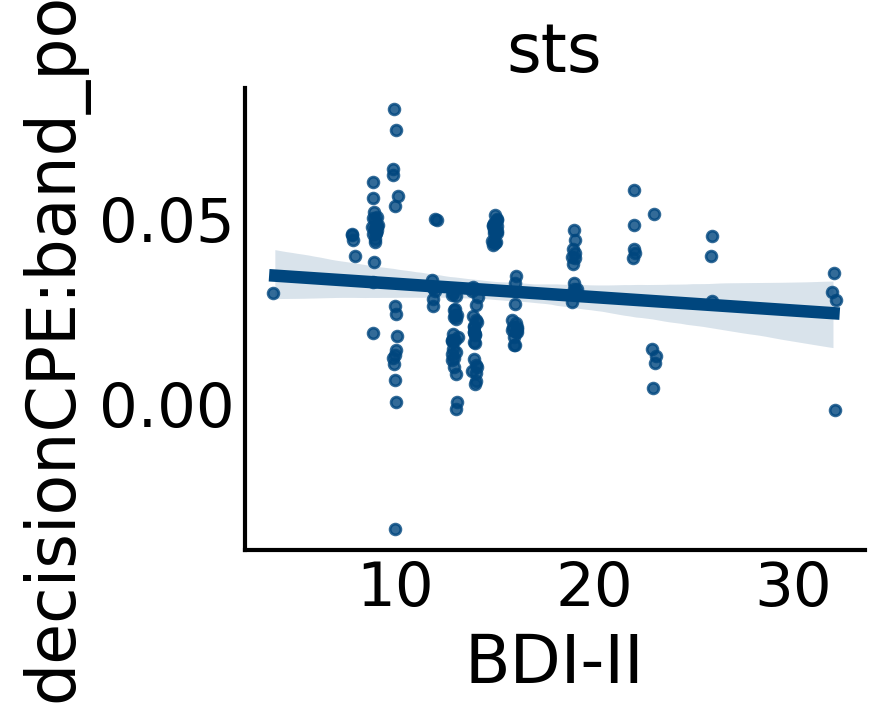

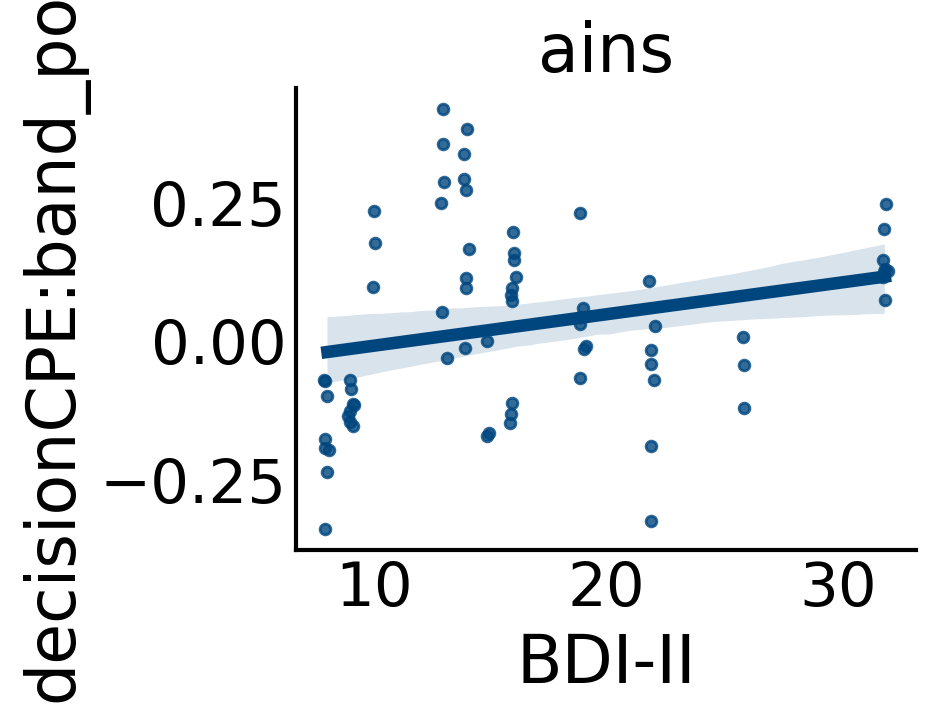

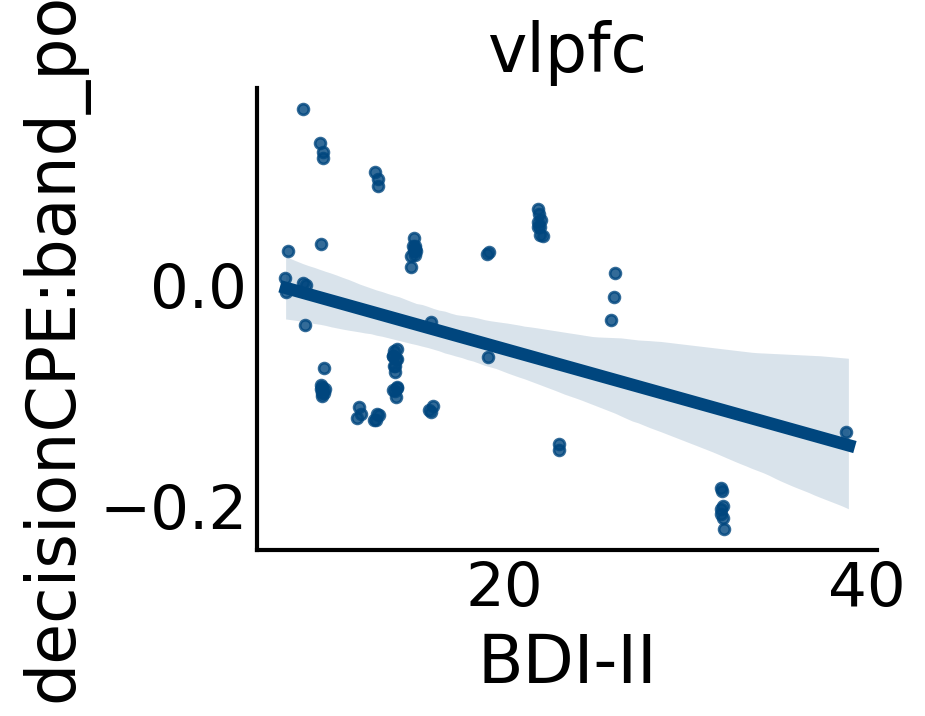

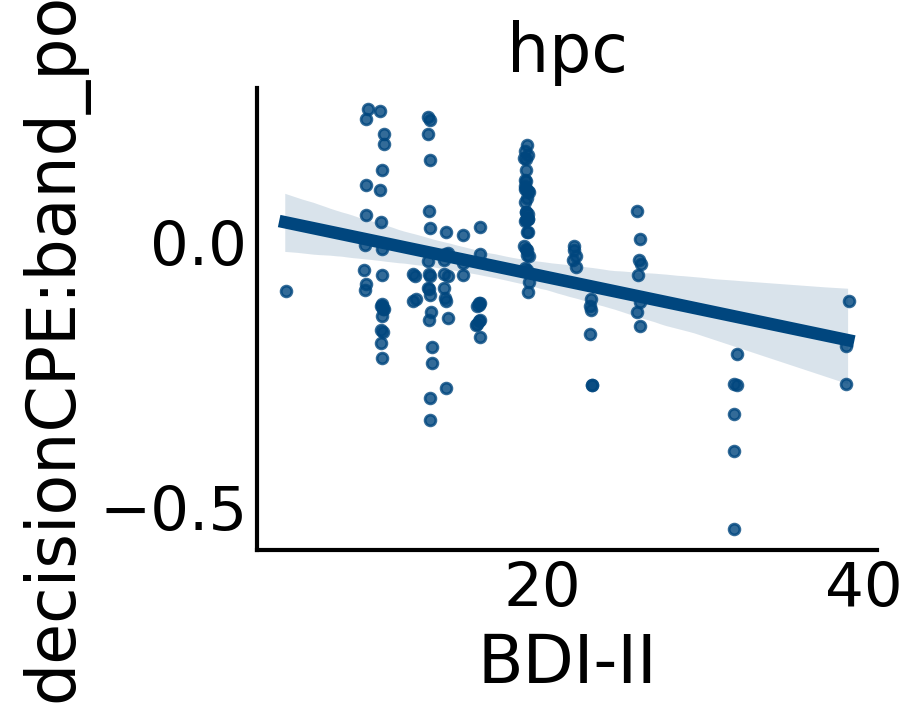

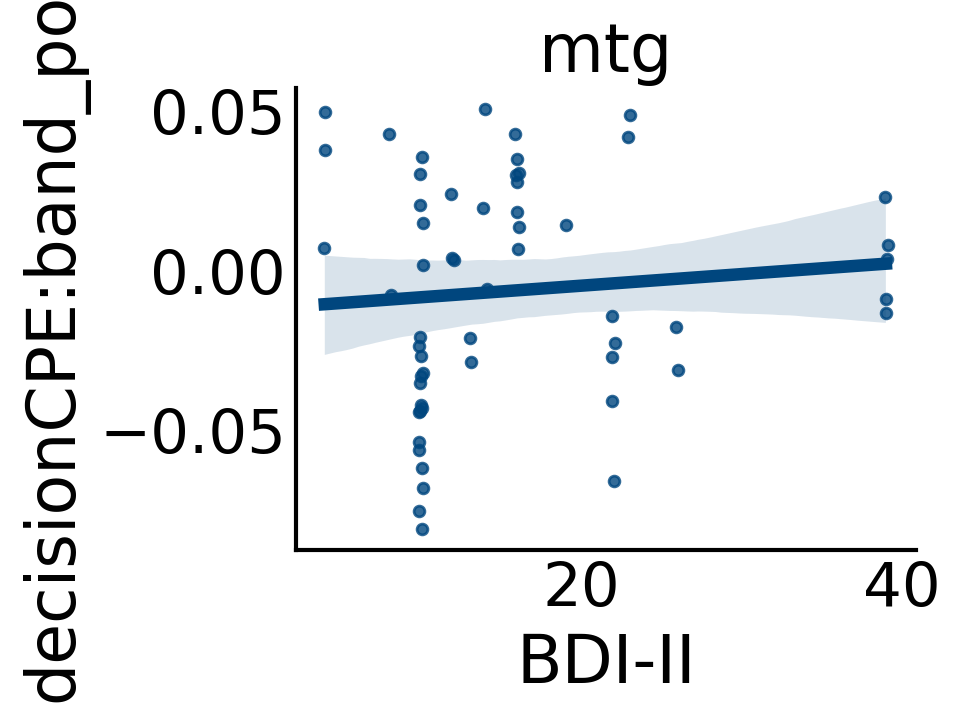

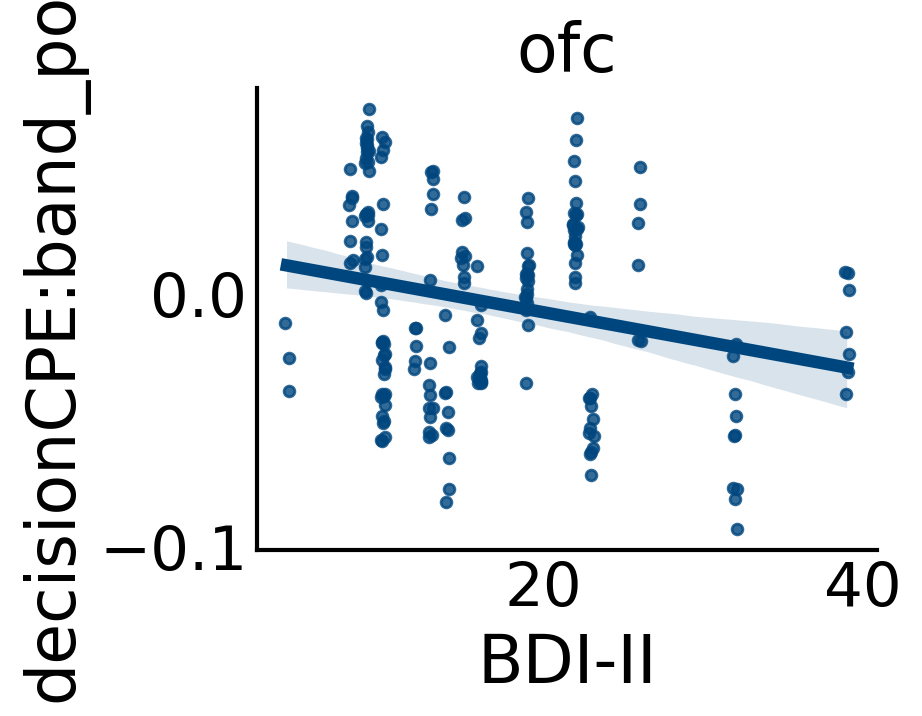

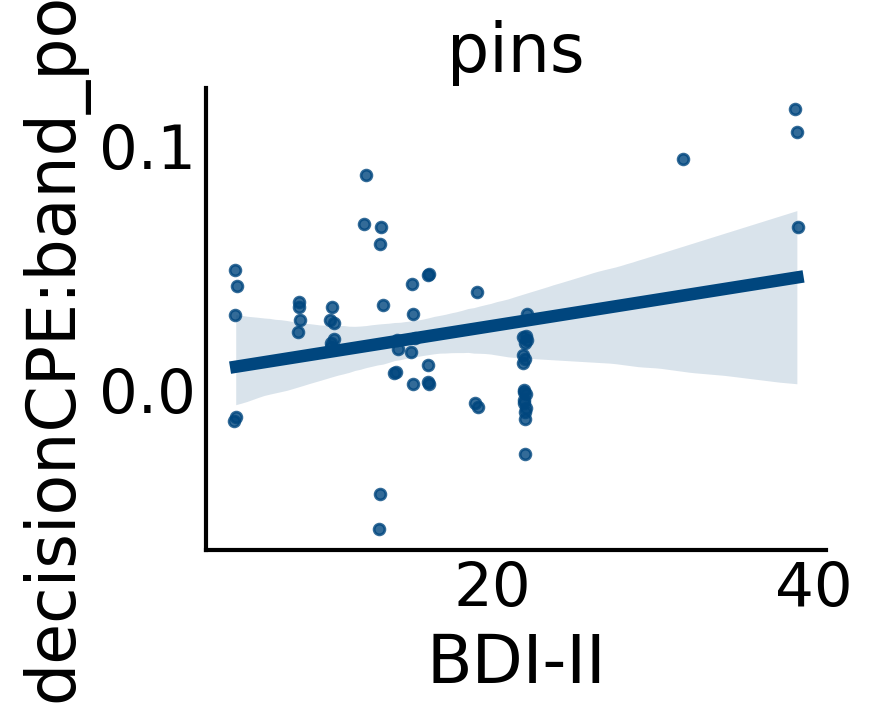

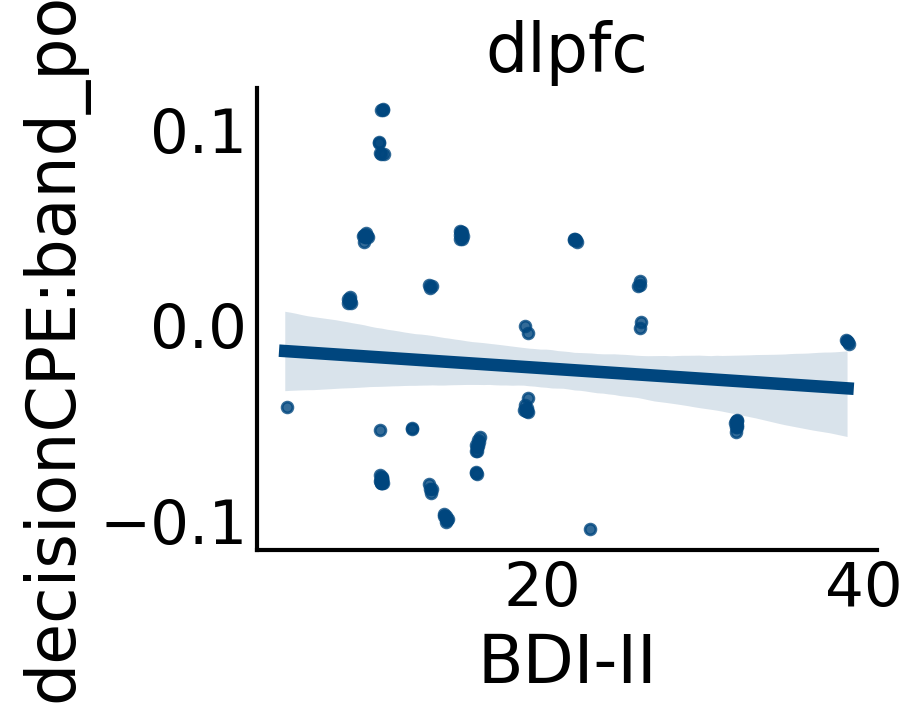

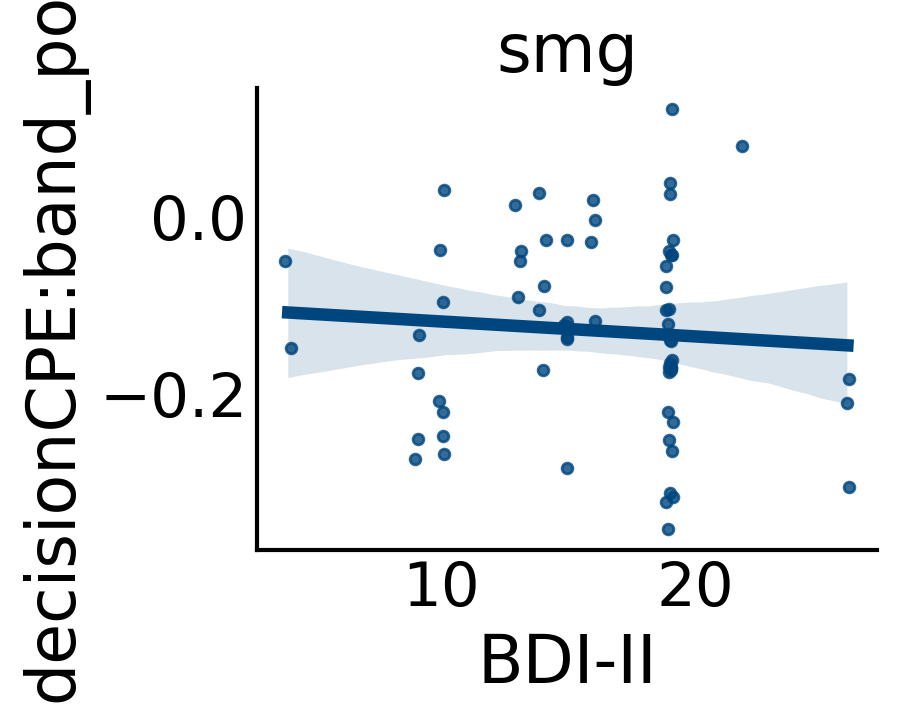

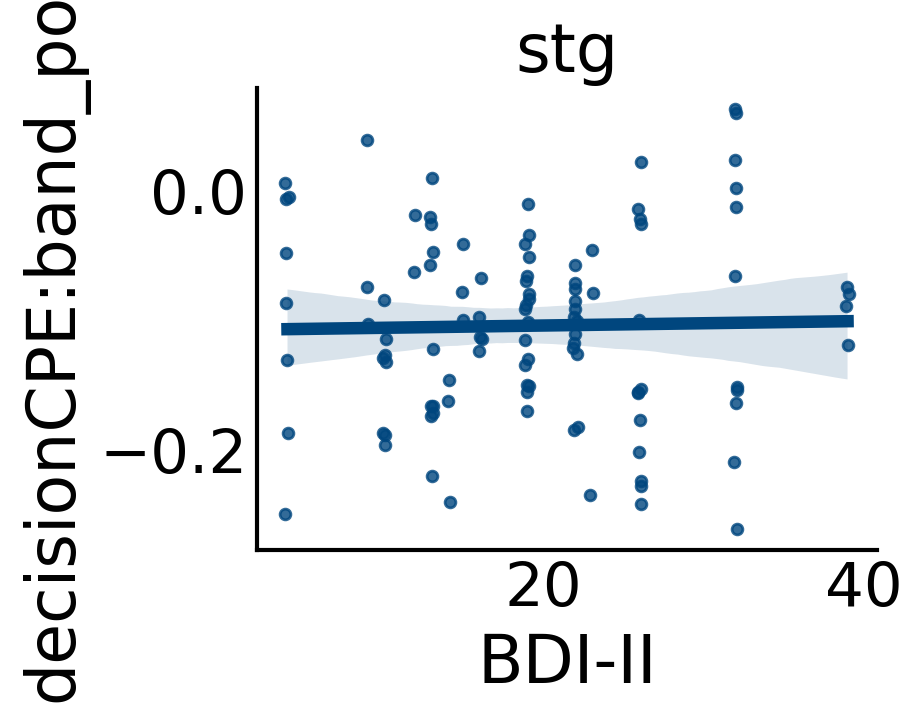

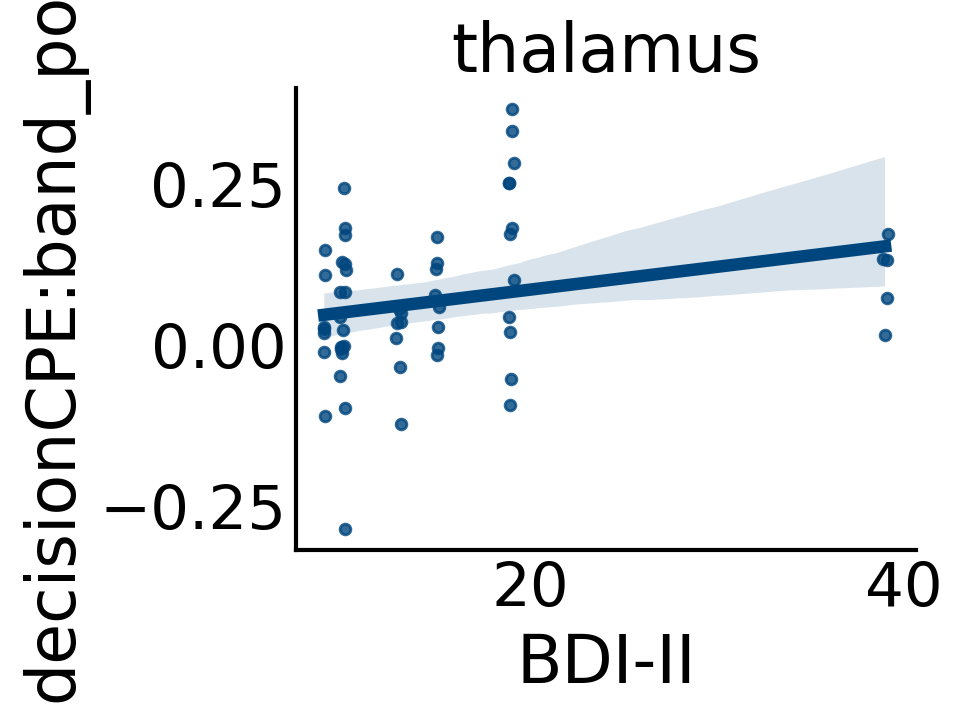

In [61]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE:band_pow',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':15}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    